# Прогнозирование оттока клиентов

# Описание проекта

Оператор связи хочет научиться прогнозировать
отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут
предложены промокоды и специальные условия. Команда оператора
собрала персональные данные о некоторых клиентах, информацию об их
тарифах и договорах.
# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.
# Цель проекта
Построить модель машинного обучения, которая на основе архивных данных будет предсказывать планирует ли клиент уходить в другую компанию, и предлгать промокоды и специальные условия точечно.

# Содержание проекта
- [x] Знакомство с исходными данными
- [x] Объединение исходных данных в одну таблицу для дальнейшей работы
- [x] Исследовательский анализ и предобработка данных
- [x] Определение целевого и обучающих признаков, разделение выборок на тренировочную и тестовую
- [x] Исключение утечки целевых признаков
- [x] Проверить корреляцию числовых признаков на наличие мультиколлинеарности
- [x] Кодирование категориальных признаков методом OrdinalEncoder
- [x] Выбор, обучение 2 моделей машинного обучения разного семейства. Будут использоваться модели: RandomForestClassifier и  CatBoostClassifier
- [x] Подбор оптимальных гиперпараметров моделей на кросс-валидации для достижения лучших результатов метрики AUCROC. Допустимый результат AUCROC 0.85 и выше. В качестве дополнительной метрики качества используем метрику accuracy
- [x] Выбор наилучшей модели и проверка ее качества на тестовой выборке.
- [x] Выводы по проделанной работе

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.utils import shuffle

from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import OrdinalEncoder

RANDOM_STATE=240423

import warnings
warnings.filterwarnings('ignore')

# Изучение исходных данных

In [2]:
contract_df = pd.read_csv('/datasets/contract_new.csv')
personal_df = pd.read_csv('/datasets/personal_new.csv')
internet_df = pd.read_csv('/datasets/internet_new.csv')
phone_df = pd.read_csv('/datasets/phone_new.csv')

Рассмотрим таблицу контракты

In [3]:
contract_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [4]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
contract_df.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [6]:
contract_df.duplicated().sum()

0

In [7]:
contract_df.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


В таблице контракты аномалий, дубликатов и пропусков нет. В поле TotalCharges тип данных нужно перевести из строчных (object) в float. Большая часть признаков - категориальные

Рассмотрим таблицу с персональными данными

In [8]:
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [9]:
personal_df.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No


In [10]:
personal_df.isna().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [11]:
personal_df.duplicated().sum()

0

In [12]:
personal_df.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


В таблице personal_df дубликатов, пропусков, аномалий нет. Типы данных корректные. Много категориальных признаков

Рассмотрим таблицу internet_df

In [13]:
internet_df.head(2)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No


In [14]:
internet_df.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7294-TMAOP,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [15]:
internet_df.isna().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [16]:
internet_df.duplicated().sum()

0

In [17]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


В таблице internet_df дубликатов, пропусков и аномалий нет. Типы данных корректные

In [18]:
phone_df.head(2)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No


In [19]:
phone_df.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,7294-TMAOP,No
freq,1,3390


In [20]:
phone_df.isna().sum()

customerID       0
MultipleLines    0
dtype: int64

In [21]:
phone_df.duplicated().sum()

0

В таблице phone_df пропусков, аномалий и дубликатов нет. Типы данных корректные

# Вывод
- рассмотрели все исходные данные
- пропусков, дубликатов и аномалий нет
- поля в таблицах в неудачном стиле, для удобной работы можем перевести в "змеинный" стиль, переведя все символы в строчный, с разделением с нижним подчеркиванием
- тип данных в таблице contract_df в поле TotalCharges для корректной дальнейшей работы нужно заменить с object на float
- объединим все таблицы методом OUTER JOIN по ключу customer_id

# Код решения

# Предобработка данных

Объеденим таблицы в одну с названием final_df по ключу customerID

In [22]:
final_df = contract_df \
    .merge(personal_df, how='outer', on='customerID') \
    .merge(internet_df, how='outer', on='customerID') \
    .merge(phone_df, how='outer', on='customerID')

In [23]:
final_df.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No


In [24]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


- Переведем поля BeginDate,EndDate в тип datetime, TotalChages в тип float64.
- После замены типа данных, обнаружили 5174 пропуска в поле EndDate. Заполним эти пропуски актуальной датой, так как пропуск означает, что клиент действующий.
- Есть пропуски в полях InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies и MultipleLines. Эти поля заполнены двумя уникальными значениями Yes, No. Заменим пропуски на "No", так как, если бы услуга была подключена, то значение было бы значение Yes

У всех клиентов с пропусками в TotalCharges одна дата BeginDate и она самая крайняя. Значит поле TotalCharges у них пустые из-за того что они еще не начали платит за услуги компании, заполним эти значения нулями.

In [25]:
#v2
final_df[final_df['TotalCharges'].isnull()].head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines


In [26]:
final_df['TotalCharges'] = pd.to_numeric(final_df['TotalCharges'], errors ='coerce')
# после замены типа данных, заполним пропуски нулями
final_df['TotalCharges'].fillna(0,inplace=True)
final_df['BeginDate']=pd.to_datetime(final_df['BeginDate'],errors ='coerce')
final_df['EndDate']=pd.to_datetime(final_df['EndDate'],errors ='coerce')

In [27]:
final_df['EndDate'].fillna('2020-02-01',inplace=True)# заполним пропуски акутальной датой
final_df['EndDate']=pd.to_datetime(final_df['EndDate'],errors ='coerce')

In [28]:
for i in (
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
          'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'
         ):
    final_df[i].fillna('No',inplace=True)

Чтобы исключить утечку целевого признака в обучающие, а также обозначить целевой признак, создадим новые поле total_days и loyality, в которых рассчитаем разницу между EndDate и BeginDate и обозначим цифрой 1 лояльных клиентов, 0 - ушедших

In [29]:
final_df['total_days']=(final_df['EndDate']-final_df['BeginDate']).dt.days

In [30]:
final_df['total_days'].describe()

count    7043.000000
mean      898.555729
std       683.130510
min         0.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: total_days, dtype: float64

In [31]:
final_df['loyality']=0
final_df.loc[final_df['EndDate']==final_df['EndDate'].max(),'loyality']=1

# Вывод
- Объединили все исходные таблицы
- Привели к корректным типы данных
- Обработали все пропуски
- Пропуски в поле EndDate заполнили сегодняшним числом, так мы обозначим лояльных клиентов, так как отсутствие EndDate означает, что клиент не ушел. Остальные клиенты с обозначеным не сегоднящним числом EndDate, будут считаться ушедшими
- Добавили поле total_days, которое позволит использовать данные из поля обучающих признаках, исключая утечку
- Добавили поле loyality, разделив клиентов на 2 категории - лояльных (1) и ушедших (0). Это и будет целевым признаком

# Исследовательский анализ данных

Рассмотрим:
- распределение клиентов по лояльности
- распределение ежемесячных расходов по лояльным клиентам
- распределение ежемесячных расходов по ушедшим клиентам
- корреляцию между количественными признаками

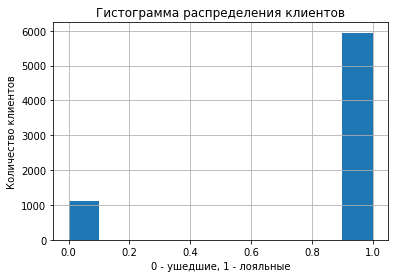

In [32]:
final_df['loyality'].hist()
plt.title('Гистограмма распределения клиентов')
plt.xlabel('0 - ушедшие, 1 - лояльные')
plt.ylabel('Количество клиентов')
plt.show()

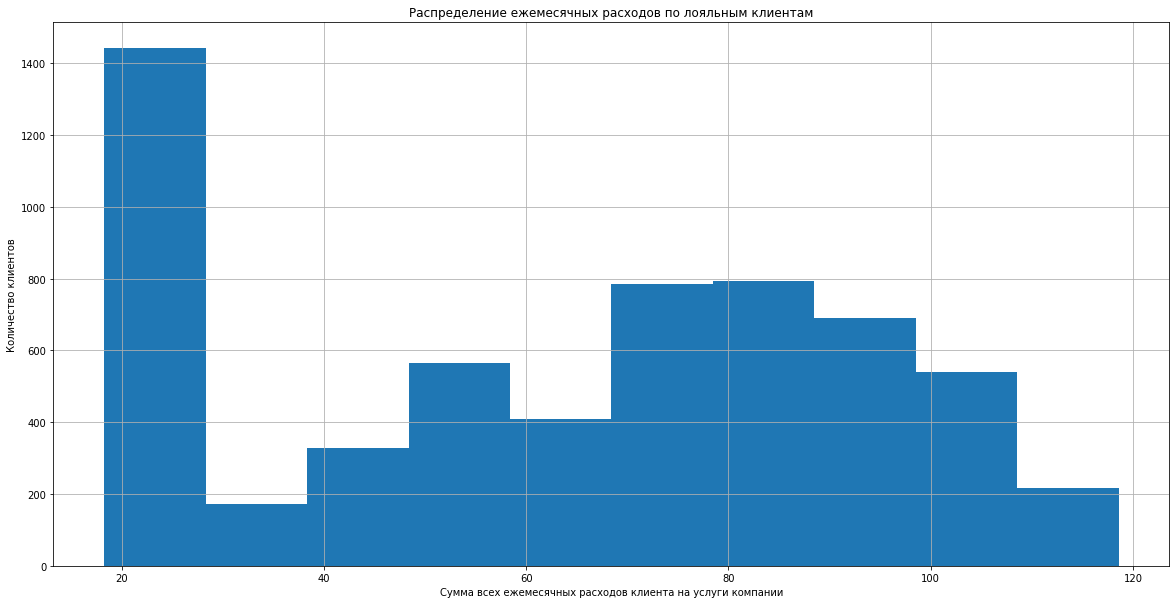

In [33]:
final_df.loc[final_df['loyality']==1,'MonthlyCharges'].hist(bins=10,figsize=(20,10))
plt.title('Распределение ежемесячных расходов по лояльным клиентам')
plt.xlabel('Сумма всех ежемесячных расходов клиента на услуги компании')
plt.ylabel('Количество клиентов')
plt.show()

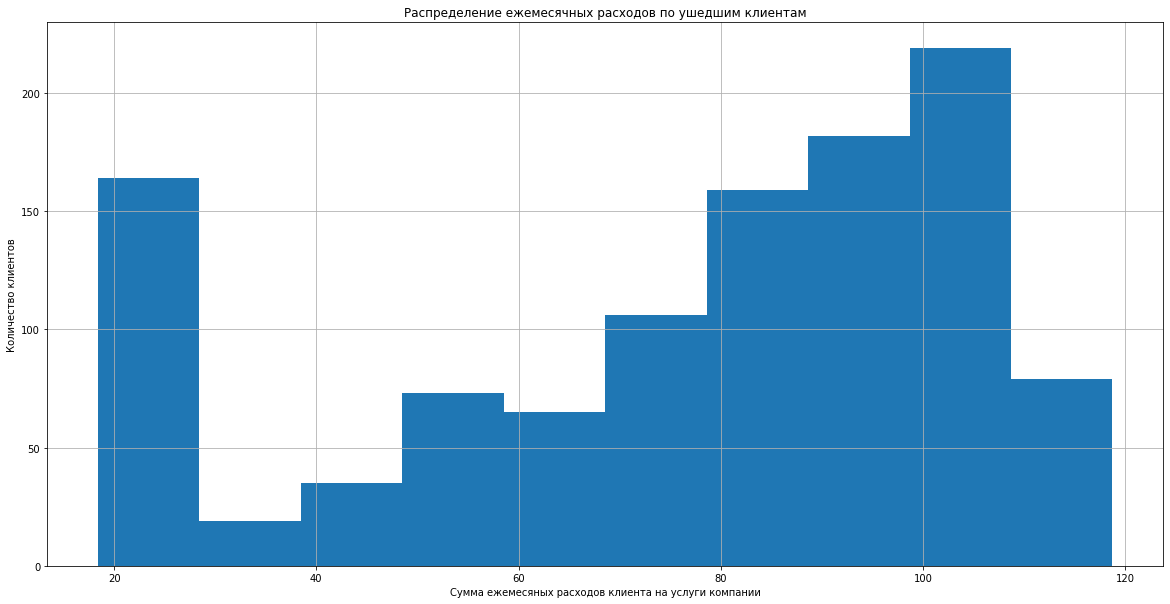

In [34]:
final_df.loc[final_df['loyality']==0,'MonthlyCharges'].hist(bins=10,figsize=(20,10))
plt.title('Распределение ежемесячных расходов по ушедшим клиентам')
plt.xlabel('Сумма ежемесяных расходов клиента на услуги компании')
plt.ylabel('Количество клиентов')
plt.show()

Корреляция между количественными признаками

In [35]:
round(final_df.drop('SeniorCitizen',axis=1).corr(),2)

,MonthlyCharges,TotalCharges,total_days,loyality
MonthlyCharges,1.00,0.63,0.22,-0.15
TotalCharges,0.63,1.00,0.82,-0.05
total_days,0.22,0.82,1.00,-0.02
loyality,-0.15,-0.05,-0.02,1.00


Видим сильную мультиколлинеарность между признаками total_days,MonthlyCharges с признаком total_charges. И целевым признаком loyality c total_days. Модели будут переоценивать важность этих признаков, лучше их убрать, так как сумма всех платежей клиента не может быть обратно пропорцианальна ежемесяным платежам. Признак TotalCharges не будем использовать в обучении.

Также есть отрицательная корреляция, -0.19, между лояльностью и суммой ежемесячных платежей

# Вывод
- лояльных клиентов существенно больше, чем ушедших. Дисбаланс целевого признака будем учитывать в настройках моделей
- среди ушедших клиентов больше группа с большими ежемесячными платежами, чем у ушедших
- признак TotalCharges не будем использовать в обучении из-за мультиколлениарности

# Разделение признаков

Сделаем 2 комплекта обучающих и целевых признаков.
- 1 комплект (features_train, target_train) будем использовать для бустинговых моделей. Признаки будут с масштабированием, без кодирования, так как в бустинговые модели можно передавать категориальные признаки напрямую.
- 2 комплект признаков с масштрабированием,кодированием (features_train_ord,target_train_ord) будем использовать для модели RandomForestClassifier 

In [36]:
numeric=['MonthlyCharges','total_days']#наименование количественных признаков для scaler

categorial = [
    'Type',
    'PaperlessBilling',
    'PaymentMethod',
    'gender',
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'InternetService', 
    'OnlineSecurity', 
    'OnlineBackup', 
    'DeviceProtection', 
    'TechSupport', 
    'StreamingTV', 
    'StreamingMovies', 
    'MultipleLines'
]# наименование категориальных признаков для ordinal

In [37]:
#Разделим признаки на обучающие и целевые
target = final_df['loyality']
features = final_df.drop(['loyality','EndDate','BeginDate','TotalCharges','customerID'], axis=1)

In [38]:
#Выборки без кодирования для бустинговых моделей
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE)

# Закодируем категориальные признаки методом OrdinalEncoder

In [39]:
#категориальные признаки, которые нужно закодировать
encoder = OrdinalEncoder(handle_unknown='error')
features_train_ord = features_train.copy()
features_test_ord = features_test.copy()
features_train_ord[categorial]=encoder.fit_transform(features_train_ord[categorial])# выборки для RFR
features_test_ord[categorial]=encoder.transform(features_test_ord[categorial])

# Сделаем масштабирование признаков

In [40]:
scaler=StandardScaler()
scaler.fit(features_train_ord[numeric])
features_train_ord[numeric]=scaler.transform(features_train_ord[numeric])
features_test_ord[numeric]=scaler.transform(features_test_ord[numeric])


In [41]:
scaler.fit(features_train[numeric])
features_train[numeric]=scaler.transform(features_train[numeric])
features_test[numeric]=scaler.transform(features_test[numeric])


Модель RandomForestClassifier

Подбор оптимальных параметров RandomForestClassifier

In [42]:
param_grid = {
    'max_depth': [5, 17],
    'n_estimators': [10, 40], 
}

model = RandomForestClassifier(random_state=RANDOM_STATE)

search = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc')
search.fit(features_train_ord, target_train)

print(search.best_params_)


{'max_depth': 5, 'n_estimators': 40}


Кросс-валидация модели RandomforestClassifier

In [43]:
# Вывод GridSearch{'max_depth': 5, 'n_estimators': 40}
model_rfr=RandomForestClassifier(random_state=RANDOM_STATE,max_depth=5,n_estimators=40)
accuracy_score_rfr_cv=cross_val_score(model_rfr, features_train_ord, target_train,cv=2, scoring='accuracy',n_jobs=-1).mean()
print('roc_auc модели RandomForestClassifier = ',round(search.best_score_,2))
print('accuracy_score модели RandomForestClassifier =',round(accuracy_score_rfr_cv,2))

roc_auc модели RandomForestClassifier =  0.81
accuracy_score модели RandomForestClassifier = 0.84


Подбор оптимальных гиперапараметров модели CatBoostClassifier

In [44]:
param_grid = {
    'learning_rate': [0.1, 0.9],
    'iterations': [10, 100],
    'l2_leaf_reg': [2, 20]
}

model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=10,cat_features=categorial,auto_class_weights='Balanced')

search = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc')
search.fit(features_train, target_train)

print(search.best_params_)

0:	learn: 0.6754881	total: 50.7ms	remaining: 457ms
9:	learn: 0.5691188	total: 71ms	remaining: 0us
0:	learn: 0.6737772	total: 3.58ms	remaining: 32.2ms
9:	learn: 0.5591477	total: 24.2ms	remaining: 0us
0:	learn: 0.6731663	total: 2.72ms	remaining: 24.5ms
9:	learn: 0.5607164	total: 24ms	remaining: 0us
0:	learn: 0.5935169	total: 2.61ms	remaining: 23.5ms
9:	learn: 0.4575344	total: 21.9ms	remaining: 0us
0:	learn: 0.5843098	total: 2.6ms	remaining: 23.4ms
9:	learn: 0.4460364	total: 22.1ms	remaining: 0us
0:	learn: 0.5799890	total: 3.93ms	remaining: 35.4ms
9:	learn: 0.4409117	total: 25.2ms	remaining: 0us
0:	learn: 0.6805689	total: 2.88ms	remaining: 25.9ms
9:	learn: 0.6000863	total: 24.7ms	remaining: 0us
0:	learn: 0.6790623	total: 2.65ms	remaining: 23.9ms
9:	learn: 0.5845312	total: 21.7ms	remaining: 0us
0:	learn: 0.6785829	total: 2.76ms	remaining: 24.9ms
9:	learn: 0.5987585	total: 24ms	remaining: 0us
0:	learn: 0.6122813	total: 2.8ms	remaining: 25.2ms
9:	learn: 0.4942066	total: 19.6ms	remaining: 0us

In [45]:
accuracy_score_ct_cv=cross_val_score(model, features_train, target_train,cv=2, scoring='accuracy',n_jobs=-1).mean()

Learning rate set to 0.015597
0:	learn: 0.6878758	total: 5.33ms	remaining: 5.32s
10:	learn: 0.6478892	total: 49.7ms	remaining: 4.47s
20:	learn: 0.6155613	total: 93.4ms	remaining: 4.35s
30:	learn: 0.5948549	total: 131ms	remaining: 4.09s
40:	learn: 0.5771863	total: 173ms	remaining: 4.04s
50:	learn: 0.5606938	total: 214ms	remaining: 3.99s
60:	learn: 0.5508645	total: 251ms	remaining: 3.87s
70:	learn: 0.5417753	total: 292ms	remaining: 3.83s
80:	learn: 0.5355332	total: 326ms	remaining: 3.7s
90:	learn: 0.5295538	total: 363ms	remaining: 3.62s
100:	learn: 0.5216974	total: 403ms	remaining: 3.58s
110:	learn: 0.5163719	total: 437ms	remaining: 3.5s
120:	learn: 0.5126903	total: 471ms	remaining: 3.42s
130:	learn: 0.5084416	total: 506ms	remaining: 3.36s
140:	learn: 0.5050296	total: 540ms	remaining: 3.29s
150:	learn: 0.5019983	total: 576ms	remaining: 3.24s
160:	learn: 0.4984886	total: 612ms	remaining: 3.19s
170:	learn: 0.4964270	total: 637ms	remaining: 3.09s
180:	learn: 0.4927493	total: 676ms	remaining

In [46]:
print('roc_auc модели CatBoostClassifier',round(search.best_score_,2))
print('accuracy_score модели CatBoostClassifier =',round(accuracy_score_ct_cv,2))

roc_auc модели CatBoostClassifier 0.86
accuracy_score модели CatBoostClassifier = 0.78


# Вывод

- Провели подбор оптимальных гиперпараметров моделей двух семейств
- С подобранными параметрами обучили с помощью кросс-валидации эти модели
- Модель CatBoostClassifier показала лучшие метрики ROC-AUC и Accuracy на кросс-валидации. Финальное тестирование будем проводить на этой модели

# Тестирование модели

In [47]:
model.fit(features_train, target_train,cat_features=categorial)
predict_fin=model.predict_proba(features_test)[:, 1]#предсказание вероятностей для roc_auc
predict_fin_1=model.predict(features_test)#предсказание для accuracy
roc_auc_fin=roc_auc_score(target_test,predict_fin)
accuracy_fin=accuracy_score(target_test,predict_fin_1)

Learning rate set to 0.020969
0:	learn: 0.6867722	total: 7.54ms	remaining: 7.53s
10:	learn: 0.6316923	total: 73.6ms	remaining: 6.62s
20:	learn: 0.5923512	total: 139ms	remaining: 6.49s
30:	learn: 0.5694941	total: 197ms	remaining: 6.14s
40:	learn: 0.5507775	total: 261ms	remaining: 6.11s
50:	learn: 0.5395105	total: 317ms	remaining: 5.91s
60:	learn: 0.5304557	total: 373ms	remaining: 5.74s
70:	learn: 0.5224431	total: 430ms	remaining: 5.63s
80:	learn: 0.5157686	total: 492ms	remaining: 5.59s
90:	learn: 0.5085316	total: 561ms	remaining: 5.61s
100:	learn: 0.5036635	total: 623ms	remaining: 5.54s
110:	learn: 0.4988933	total: 683ms	remaining: 5.47s
120:	learn: 0.4951805	total: 740ms	remaining: 5.37s
130:	learn: 0.4917960	total: 796ms	remaining: 5.28s
140:	learn: 0.4889185	total: 852ms	remaining: 5.19s
150:	learn: 0.4850661	total: 912ms	remaining: 5.13s
160:	learn: 0.4820996	total: 972ms	remaining: 5.07s
170:	learn: 0.4802014	total: 1.02s	remaining: 4.95s
180:	learn: 0.4790080	total: 1.07s	remainin

In [48]:
print('ROC-AUC модели CatBoostClassifier на финальном тестировании ',round(roc_auc_fin,2))
print('accuracy модели CatBoostClassifier на финальном тестировании ',round(accuracy_fin,2))

ROC-AUC модели CatBoostClassifier на финальном тестировании  0.9
accuracy модели CatBoostClassifier на финальном тестировании  0.81


In [49]:
importances_df = pd.DataFrame(search.best_estimator_.feature_importances_, index = features_test.columns, columns=['importances'])
importances_df = importances_df.sort_values(by='importances', ascending=False)
importances_df.head(5)

,importances
total_days,41.486724
MonthlyCharges,14.679395
Type,8.796997
PaymentMethod,5.763451
Partner,5.349824


# Вывод

- ROC-AUC модели CatBoostClassifier на финальном тестировании  0.90
- accuracy модели CatBoostClassifier на финальном тестировании  0.81
- Вывели также топ 5 важных признаков для обучения. total_days, MonthlyCharges, Type, PaymentMethod,Partner

# Общий вывод 

В ходе работы мы
- изучили  исходные данные
- сделали предобработку и исследовательский анализ данных
- добавили в таблицу поле total_days (длительность пользования услугами компании), добавили в обучающие признаки
- разделили клиентов на лоляльных и ушдеших, добавили в целевые признаки
- убрали из обучающих признаков поля 'loyality','EndDate','BeginDate' для исключения утечки целевых признаков в обучающие, и поле'TotalCharges' компенсировав мультиколлинеарность с полем total_days
- сделали масштабирование, и кодирование обучающих признаков
- выявили и учли дисбаланс классов внутри модели
- запустили подбор оптимальных гиперпараметров для моделей и проверили качество моделей на кросс-валидации
- вывели топ-5 самых важных признаков для предсказания лояльности клиента (total_days, MonthlyCharges, Type, PaymentMethod,Partner)
- выбрали лучшей моделью для финального тестирования CatBoostClassifier с гиперпараметрами 'iterations': 100, 'l2_leaf_reg': 2, 'learning_rate': 0.9
- roc_auc CatBoostClassifier на кросс-валидации = 0.86


- ROC-AUC модели CatBoostClassifier на финальном тестировании 0.90
- accuracy модели CatBoostClassifier на финальном тестировании 0.81
- Опираясь на метрики качества модели можно ее рекомендовать для прогноза клиентов, которые планирую уходить из компании и предлагать таким клиентам промокод с более выгодными условиями

Отчет
- Итоговое решение было полностью реализовано  в соответствии с планом проекта. Все пункты выполнены

Во время выполнения проекта столкнулись со следуюущими трудностями
- При использовании двух метрик качества AUC-ROC и accuracy на финальном тестировании нужно было делать 2 массива с прогнозами. Для ROC-AUC нужно вычислить предсказание с вероятностью принадлежности к целевому классу (predict_proba), для accuracy предсказание целевого признака (predict). Других трудностей не было 

- Все этапы в работе важны. Высокого значения метрики AUC-ROC модели CatBoostClassifier удалось добиться благодаря предобработке данных, корректному определению обучающих и целевых признаков, учету дисбаланса классов в настройках модели, масштабированию обучающих признаков, подбору отпимальных гиперпараметров модели на кросс-валидации
- в проекте мы использовали модель 
            CatBoostClassifier(cat_features=categorial, random_state=240423, iterations=50, learning_rate=0.4,
            l2_leaf_reg=2,  auto_class_weights='Balanced').
- В cat_features переданы названия поле с категориальными переменными, гиперпараметры iterations=50,learning_rate=0.4,l2_leaf_reg=2 были подобраны при помощи GridSearchCV, auto_class_weights='Balanced' нужен для учета дисбаланса целевых классов
- список обучающих признаков, которые использовались для обучения (
       'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines', 'total_days'), где
        total_days=(EndDate-BeginDate), создан дополнительно для обучения
- 'loyality' – целевой бинарный признак, обозначет 1 лояльных клиентов, 0 – ушедших. (Отметили по столбцу EndDate)

'EndDate','BeginDate' – убраны из обучающих, чтобы исключить утечку целевых признаков в обучающие

'TotalCharges' – исключен из обучающих из-за мультиколлениарности с MonthlyCharges и total_days

'customerID' -исключен из обучающих

размер тестовой выборки 0.25

random_state=240423

-  При изменении типа данных (поле TotalCharges, EndDate) на корректный, получали много пропусков. Проанализировав эту выборку с пропусками в поле выяснили, что пропуски в TotalCharges относятся к клиентам новчикам, заполнили пропуски 0. Пропуски в EndDate относятся к лояльным клиентам, которые еще пользуются услугами компании, заполнили датой выгрузки датасета. 
